In [1]:
import rfnetwork as rfn
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mpl_markers as mplm

np.set_printoptions(suppress=True, threshold=12)

# frequency range for plots
frequency = np.arange(200, 700, 10) * 1e6 
f0 = 440e6 # design frequency

# Amplifier Tuning with Internal Probes

This examples demonstrates how internal probes can be used to tune an amplifier. The amplifier used is a 8W UHF FET 
manufactured by STM, [PD55008-E](https://www.st.com/en/radio-frequency-transistors/pd55008-e.html). 

This amplifier is bilateral ($S_{12}\neq 0$) which can make tuning difficult. Network probes allow the reflection coefficients at the amplifier, $\Gamma_{in}$ and $\Gamma_{out}$, to be plotted while the amplifier is connected to matching networks. In practice, the output load should be tuned for maximum output power and not maximum gain, but
for the purposes of this example, the amplifier is conjugately matched at both input and output.

Start by importing the s-parameter data from the manufacturer. S-parameters are available at multiple different drain
currents, load each of them into a single `Component`.

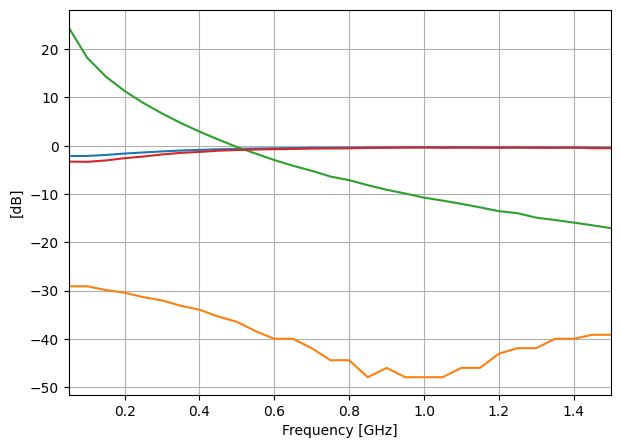

In [2]:
DATA_DIR = Path("data/PD55008E_S_parameter")

pa_8w = rfn.Component_SnP(
    file={
        150: DATA_DIR / "PD55008E_150mA.s2p", 
        800: DATA_DIR / "PD55008E_800mA.s2p", 
        1500: DATA_DIR / "PD55008E_1500mA.s2p"
    }
)

# 50 ohm microstrip model, substrate is from the amplifier evaluation board.
ms50 = rfn.elements.MSLine(
    h=0.030, 
    er=2.55, 
    w=0.08,
    loss_tan=0.017,
)

# plot the s-parameters of the untuned device
pa_8w.plot();

Plot the source and load stability circles, along with the desired input impedance for the output matching network.

Since $|S_{22}|$ and $|S_{11}|$ are both $<1$, the unstable region is inside the circles.

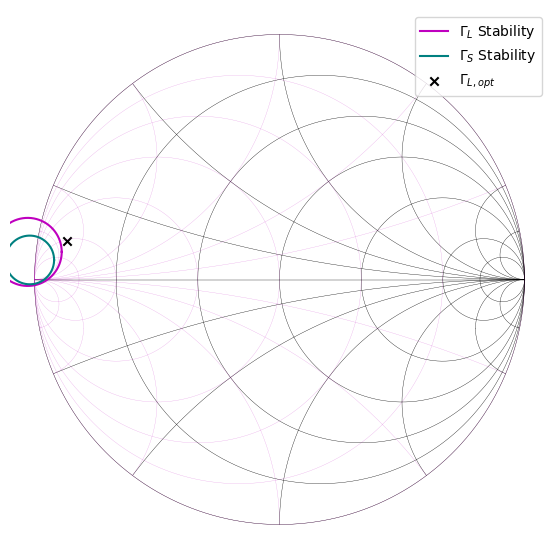

In [3]:
def init_smith_plot():
    axes = pa_8w.plot_stability_circles(f0, load_kwargs=dict(color="m"), source_kwargs=dict(color="teal"))

    # plot the conjugate match for S22 of the amplifier
    s22 = pa_8w.evaluate(f0)["s"].sel(b=2, a=2)
    axes[0].scatter(np.conj(s22).real, np.conj(s22).imag, marker="x", color="k", label=r"$\Gamma_{L, opt}$")

    return axes[0]

axes = init_smith_plot()
axes.legend();

The input impedance of the load that yields maximum gain is on the edge of stability. This example attempts to get as
close as possible to the stability threshold so that gain is maximized.

First, design a matching network for the load that presents a reflection coefficient of $\Gamma_{L,opt}$ to the output 
of the amplifier. This is done in isolation, and can be tweaked later if the input match perturbs $\Gamma_{out}$ of the 
amplifier.

## Output Matching Network

In [4]:
class pa_output(rfn.Network):
    """
    PA output matching network
    """
    ms1 = ms50(0.4) # length is in inches
    c1 = rfn.elements.Capacitor(65e-12, shunt=True)
    ms2 = ms50(1.1)
    c2 = rfn.elements.Capacitor(15e-12, shunt=True)

    # Port 1 will connect to the amplifier output
    cascades = [
        ("P1", ms1, c1, ms2, c2, "P2"),
    ]
    
    # individual probes can be assigned here, but setting to True
    # creates a probe at every internal node of the network.
    probes=True

m_out = pa_output()

# get the s-matrix data of the network. The probe data is included in the rows below the 2x2 matrix data.
# Probes are defined as the the voltage wave leaving the port.
np.abs(m_out.evaluate(f0)["s"])

ldarray([[[0.90170357, 0.41887345],
          [0.41887345, 0.86884177],
          [0.99831567, 0.00106348],
          ...,
          [0.43063667, 1.93077755],
          [0.60335227, 1.87784431],
          [0.43425682, 1.94201268]]], shape=(1, 8, 2))
Coordinates: (1, 8, 2)
  frequency: [4.4e+08]
  b: [1, 2, 'ms1|2', ... 'ms2|1', 'ms2|2', 'c2|1']
  a: [1, 2]

The probe data is used to plot the reflection coefficient looking into each component in the network. Starting with the shunt capacitor C2, the 50 ohm impedance at the load is moved down along the follows the constant conductance circle to the blue
dot. This point is the impedance looking into the the C2 capacitor from the left, and is calculated by dividing the voltage
wave leaving port 1 of C2 by the voltage wave leaving port 2 of the microstrip line ms2.

The effect from each component cascades until we arrive at S11, where the impedance is very close to $\Gamma_{L,opt}$. This network will present the impedance at S11 (shown by the red dot to the output of the amplifier).


<img src="data/img/pa_tuning_output.svg" style="background-color: #FFFFFF;">

<Axes: >

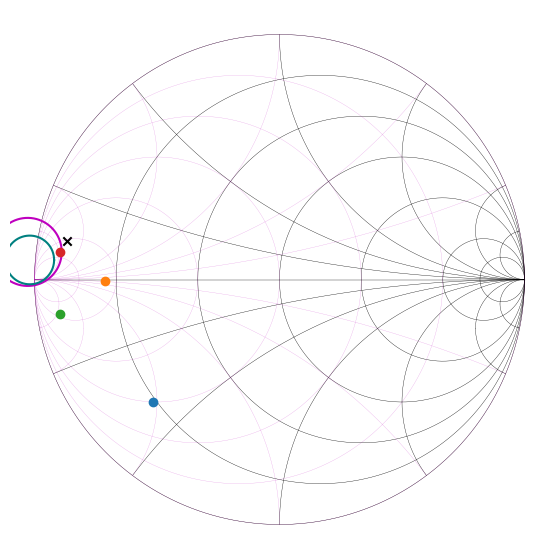

In [5]:
ax = init_smith_plot()
m_out.plot_probe(
    f0, ("c2|1", "ms2|2"), ("ms2|1", "c1|2"), ("c1|1", "ms1|2"), input_port=1, fmt="smith", marker="o", axes=ax
)
m_out.plot(f0, (1, 1), fmt="smith", marker="o", axes=ax)

## Input Matching Network

For the input matching network, connect the output match to the amplifier and work backwards from the amplifier's input 
port. 

When a network is embedded inside another network, the probe names are prepended with the sub-network name.

In [6]:
class pa_input(rfn.Network):
    """
    Amplifier input matching network
    """
    c2 = rfn.elements.Capacitor(12e-12, shunt=True)
    ms3 = ms50(1.1)
    c1 = rfn.elements.Capacitor(40e-12, shunt=True)
    ms2 = ms50(0.4)
    r1 = rfn.elements.Resistor(2)

    # Port 2 will connect to port 1 of the amplifer
    cascades = [
        ("P1", c2, ms3, c1, ms2, r1, "P2"),
    ]

    probes=True


class pa_match(rfn.Network):
    """
    Matched amplifier circuit
    """
    m_in = pa_input()
    u1 = pa_8w(state=150)
    m_out = pa_output()

    cascades = [
        ("P1", m_in, u1, m_out, "P2"),
    ]

    probes=True

pa_m = pa_match()

# get the s-matrix data of the tuned amplifier network. Probes from the input matching sub-network have the assigned 
# name of the network component, m_in, prepended to the probe name. 
# Probes from the output matching sub-network have the assigned name of the network component, m_out, 
# prepended to the probe name. 
np.abs(pa_m.evaluate(f0)["s"])

ldarray([[[0.28826199, 0.08197042],
          [5.61673092, 0.2772706 ],
          [2.34089797, 0.14127318],
          ...,
          [5.77446545, 1.58541148],
          [8.09043233, 1.27585008],
          [5.8230086 , 1.59715824]]], shape=(1, 20, 2))
Coordinates: (1, 20, 2)
  frequency: [4.4e+08]
  b: [1, 2, 'm_in|2', ... 'm_out.ms2|1', 'm_out.ms2|2', 'm_out.c2|1']
  a: [1, 2]

Starting with $\Gamma_{in}$ of the amplifier, the impedance is brought in from the edge of smith chart (where it is nearly 
unstable) with a small resistive load. In practice, this would need to take into account the gate bias network, but
is neglected here for simplicity. 

The impedance is transformed by each component until finally we arrive at S(1,1) (the brown marker). This is intentionally not brought exactly to 50 ohms for two reasons, 1) it will push the $\Gamma_{out}$ closer to instability, and 2) it makes
the matching network a bit more broadband, as shown later.

<img src="data/img/pa_tuning_input.svg" style="background-color: #FFFFFF;">

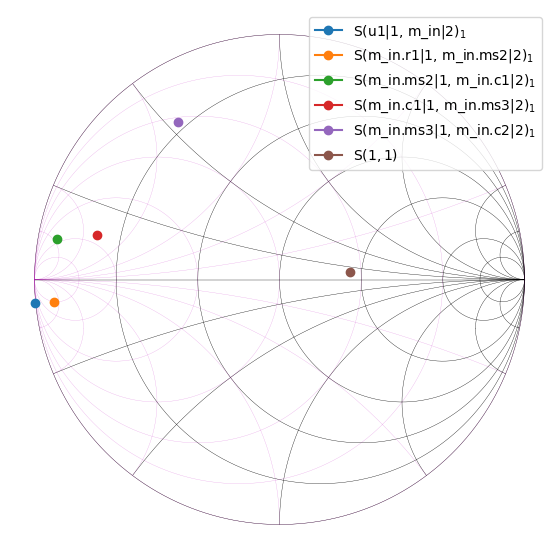

In [7]:
ax = pa_m.plot_probe(
    f0, 
    ("u1|1", "m_in|2"), 
    ("m_in.r1|1", "m_in.ms2|2"), 
    ("m_in.ms2|1", "m_in.c1|2"), 
    ("m_in.c1|1", "m_in.ms3|2"), 
    ("m_in.ms3|1", "m_in.c2|2"),
    input_port=1, fmt="smith", marker="o"
)
pa_m.plot(f0, 11, fmt="smith", marker="o", axes=ax)
ax.legend()

## Output Matching Network, Revisited  

With the input matching network connected, let's revisit the output matching network and see how well it matches
$\Gamma_{out}$ to the 50 ohm load impedance. This time, the reflection coefficients are plotted starting from the amplifier output and work back towards the 50 ohm load.

<img src="data/img/pa_tuning_output2.svg" style="background-color: #FFFFFF;">

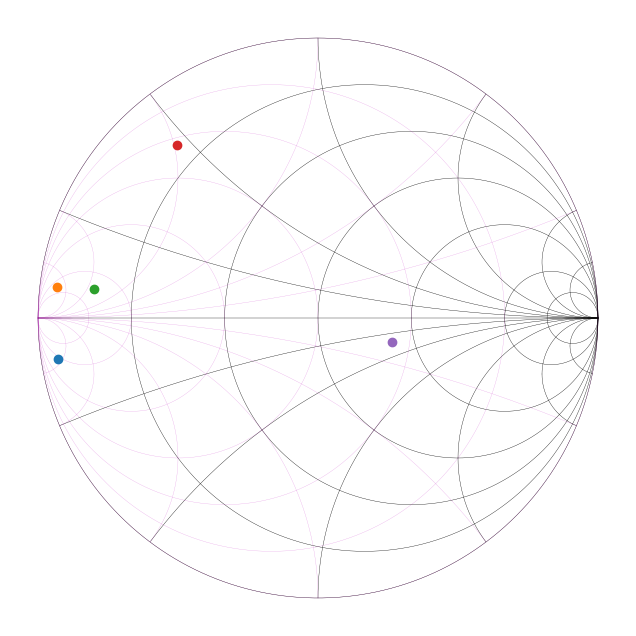

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rfn.plots.format_smithchart(ax)

pa_m.plot_probe(
    f0, 
    ("u1|2", "m_out|1"), 
    ("m_out.ms1|2", "m_out.c1|1"),
    ("m_out.c1|2", "m_out.ms2|1"),
    ("m_out.ms2|2", "m_out.c2|1"),
    input_port=2, fmt="smith", marker="o", axes=ax
)
pa_m.plot(f0, 22, fmt="smith", marker="o", axes=ax);

## Amplifier Bandwidth

The plot below shows the tuned amplifier performance over a range of frequencies.

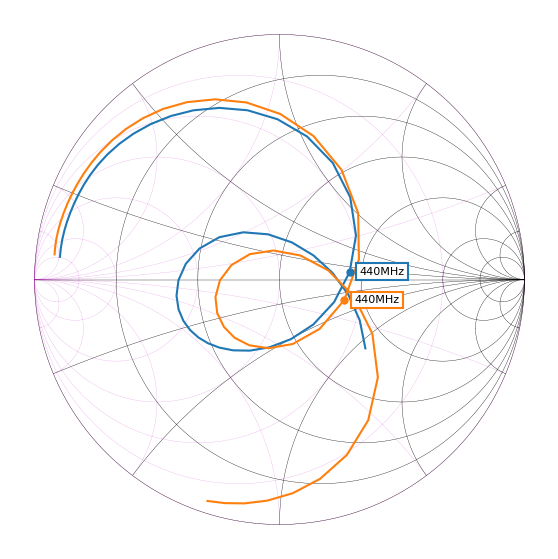

In [9]:
ax = pa_m.plot(frequency, 11, 22, fmt="smith")
rfn.plots.smithchart_marker(ax, frequency, f0)

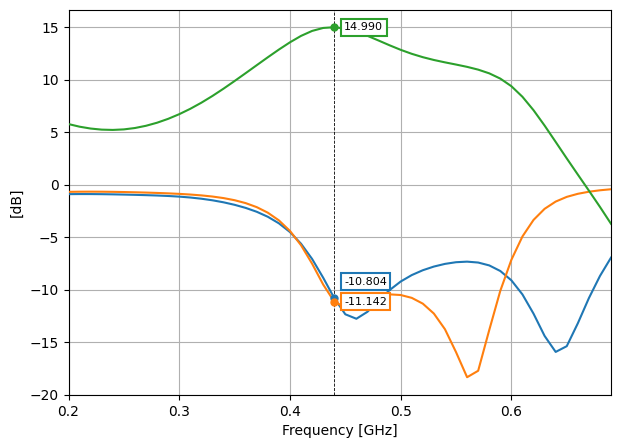

In [10]:
pa_m.plot(frequency, 11, 22, 21, fmt="db")
mplm.line_marker(x=f0/1e9)

Plot $\Gamma_{in}$ and $\Gamma_{out}$ of the amplifier over the bandwidth. Even with the input resistor r1, $\Gamma_{in}$ is unstable at frequencies below the design frequency of 440MHz.

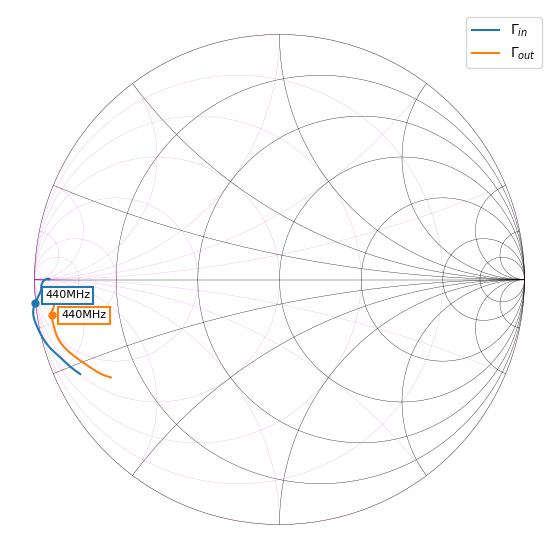

In [11]:
ax = pa_m.plot(frequency, ("u1|1", 1), ref=("m_in|2", 1), fmt="smith")
ax = pa_m.plot(frequency, ("u1|2", 2), ref=("m_out|1", 2), fmt="smith", axes=ax)

ax.legend(ax.lines[-2:], [r"$\Gamma_{in}$", r"$\Gamma_{out}$"])
rfn.plots.smithchart_marker(ax, frequency, f0)